# Cell TV - whoop whoop
This script showcases a bunch of functions that each show a characteristic feature for a cell in a given recording session to get the best overview possible of what this cell is doing. 

The script will receive mouse, session, basepath info and a cell number. It will show:
- mean registered image with selected cell outline
- crop out of mean registered image with just that cell
- full df/f trace, with rewards/position highlighted by vertical lines
- heatmap of reward PSTH trials 
- mean +- SEM of reward psth (with lick rate and average position change in grey underneath)
- mean +- SEM of 10 (or less) landmark PSTHs
- speed tuning
- position binned activity 
- latent structure split of position plots
- goal progress polar plot
- correlation of cell trace with all other cells

It does not cover population level analyses: put into a separate script
- decoding of specific variables from the whole population (position, goal progress, task state, latent state)


In [1]:
import os
import sys
import importlib as imp
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks
from barcode import barcode_util
from barcode import extract_barcodes
import pickle
import parse_session_functions
from suite2p.extraction import dcnv
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
import matplotlib.patches as patches
import cellTV_functions as cellTV
imp.reload(cellTV)
imp.reload(parse_session_functions)
#suppress the warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Provide mouse and session information

In [2]:
mouse = 'TAA0000066'
stage = '-t6'
base_path = '/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2/'
imaging_path, config_path, frame_ix, date1, date2 = cellTV.get_session_folders(base_path, mouse, stage)

## Extract neural and behavioural data

In [3]:
f, fneu, iscell, ops, seg, frame_rate = cellTV.load_img_data(imaging_path)
dF = cellTV.get_dff(f, fneu, frame_ix, ops)

Calculated dF/F with the following parameters: baseline=maximin, win_baseline=60.0, sig_baseline=10.0, fs=45,perctile_baseline=8.0


Training and Imaging
Total rewards considered here:  178
Total rewards not considered here:  0
Total assistant and manual rewards:  0
Total rewards considered here:  178
Total rewards not considered here:  0
Total assistant and manual rewards:  0
Reward time lag from lm entry:  24.0
Total licks considered here:  3401


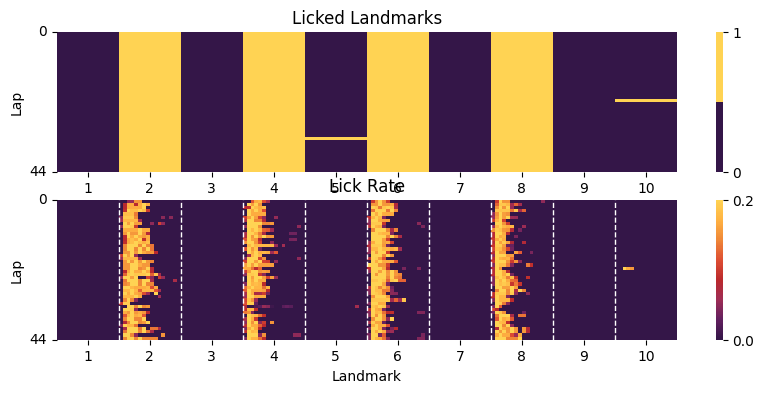

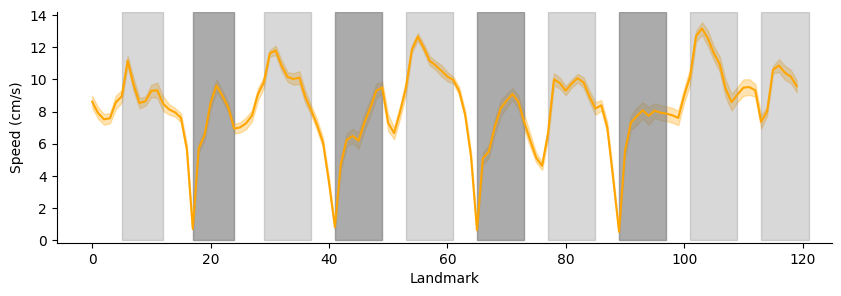

Number of laps =  1


In [4]:
if stage in ['-t3','-t4','-t5', '-t6']:
    session = parse_session_functions.analyse_npz_pre7(mouse, date2, stage, plot=False)
else:
    session = parse_session_functions.analyse_npz(mouse,date2,plot=True)

## Select a cell and display its mean fluorescence and segmentation

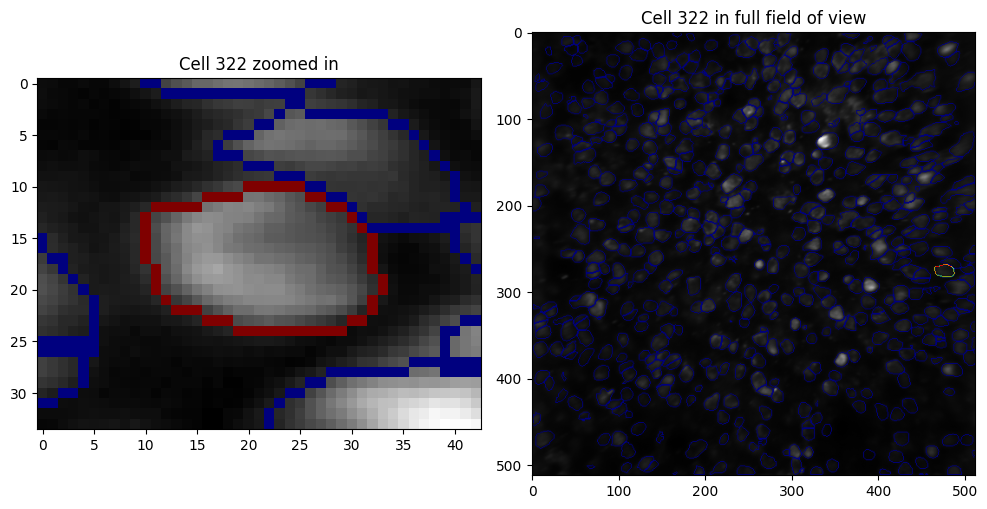

In [5]:
cell = 322
cellTV.show_cell_fov(cell,ops,seg)

Get the trace for this cell and plot the full trace + position + reward + LM info

KeyError: 'modd1'

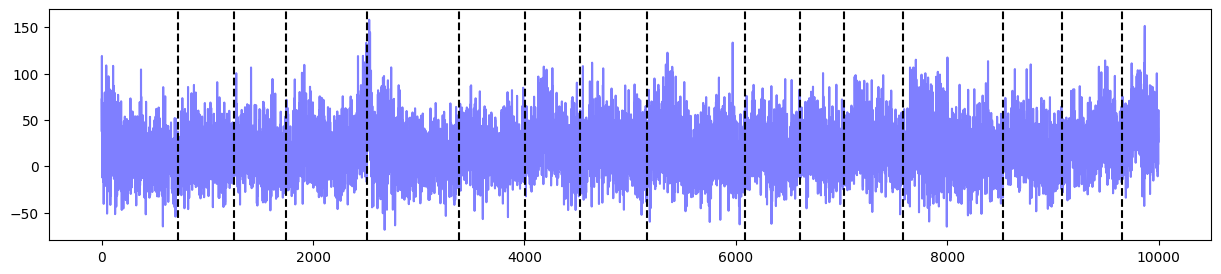

In [6]:
dF_cell = cellTV.extract_cell_trace(dF,cell,plot=True,session=session,frame_range=[10000,20000])

## Basic tuning properties

### Reward tuning

Number of rewards: 158
Number of outliers: 1
Number of rewards after removing outliers: 157


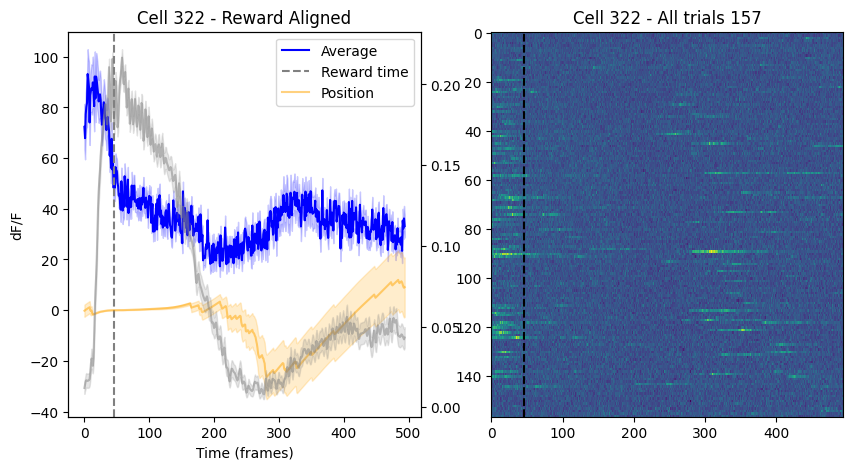

In [ ]:
cell_rewards = cellTV.extract_reward_tuning(dF, cell, session, frame_rate=45 ,window_size = [-1,10], plot=True)

### Position tuning
Heads up: Position analysis makes no sense in pseudorandom corridors (like t3 and t4), ignore that for these sessions

In [ ]:
fr_per_bin, bin_edges = cellTV.extract_position_tuning(dF, cell, stage, session, frame_rate=45, bins=200, plot=True)

AssertionError: This function has not been adapted to continuous corridors yet.

### Landmark tuning (frame window around LM entry based on position)

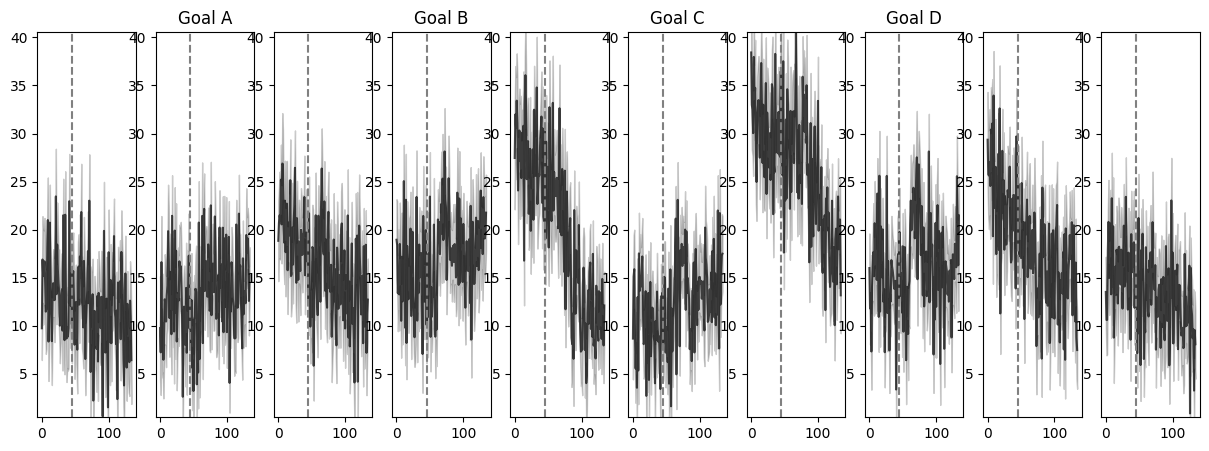

In [ ]:
landmark_frames, lm_entries = cellTV.extract_lm_tuning(dF, cell, session, stage, frame_rate=45, window_size=[-1, 2], plot=True)

### Goal progress tuning
Based on reward indices (binned by time in between)

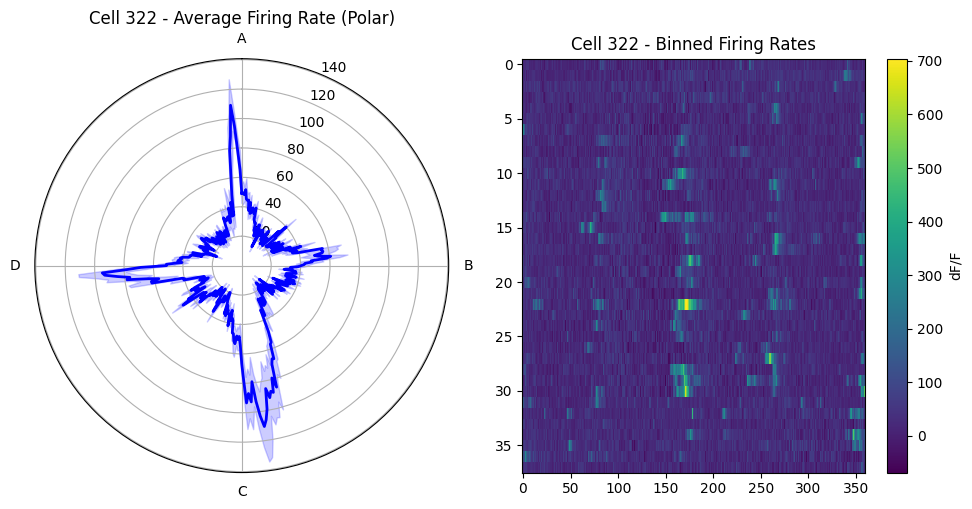

In [ ]:
binned_all, reward_ix = cellTV.extract_goal_progress(dF,cell,session,frame_rate = 45,bins=90,plot=True,shuffle=False)

Alternatively, 'goal'-progress can be calculated based on any event indices and with respect to any number of goals. If you supply reward indices and n-goals = 4, this function is identical to the above.

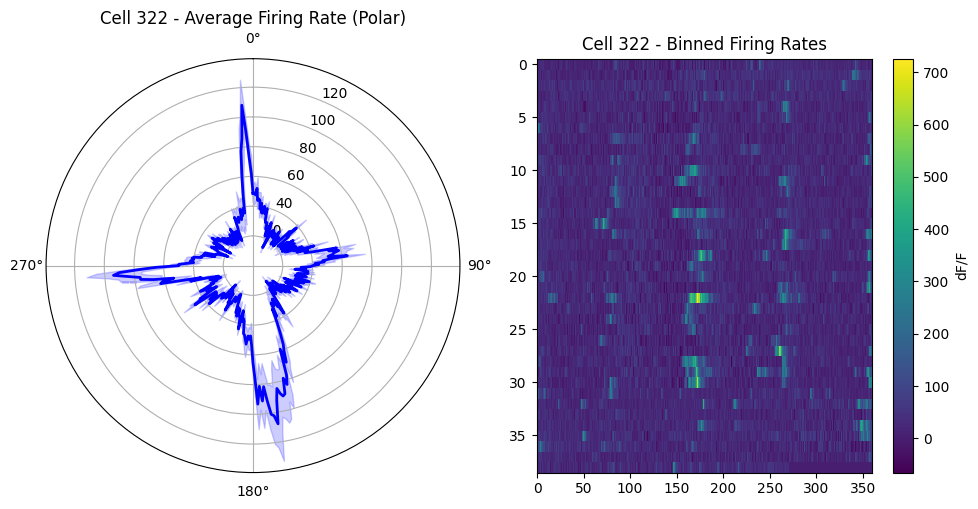

In [ ]:
binned_all = cellTV.extract_arb_progress(dF, cell, reward_ix, 4, 90, plot=True,shuffle=False)

One way of quantifying goal tuning is to calculate the max/min/mean activity in any phase and do max-min/mean and compare this to a shuffle distribution (shuffle activity per trial across phase bins).

Real score for cell 322 is 2.08, phase preference is 84.75, state preference is 1.00
P-value for cell 322 is 0.00000000


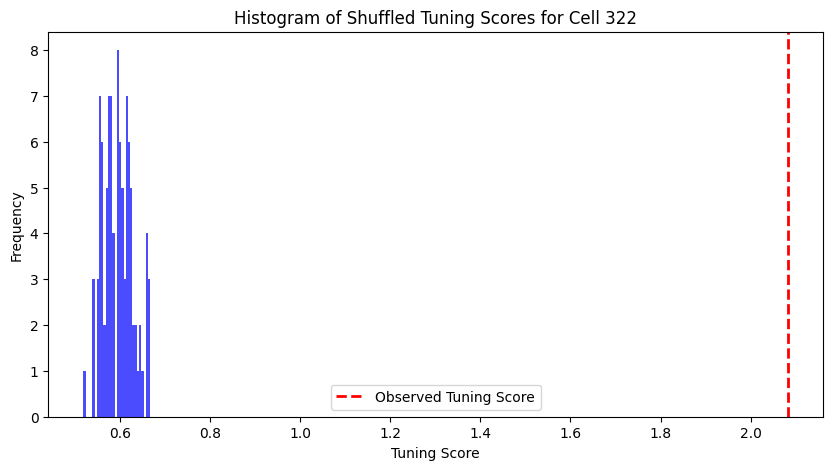

In [ ]:
real_score,shuffled_scores,phase_pref,state_pref = cellTV.calc_goal_tuningix(dF, cell, session, condition='goal',event_frames=None,n_goals=4, frame_rate=45, bins=90,shuffle=True, plot=True)

In [ ]:
#bin goal progress by position instead of time

Example of alternative 'goal'-progress calculation based on licked landmarks (i.e. sth like internal goals). The same tuning index calculation as above can be done.

In [ ]:
imp.reload(parse_session_functions)
print(session['num_laps'])
print(session['licks_per_lap_frames'])

86
[119598 119603 119609]


In [ ]:
#look for internal goal progress by considering each licked landmark as a goal (regardless of reward)
imp.reload(parse_session_functions)

lick_frames, lin_first_licks = cellTV.extract_lick_tuning(dF, cell, session, frame_rate=45, window_size=[-1,5], plot=False)
lin_first_licks = np.delete(lin_first_licks, np.where(lin_first_licks < 0)[0])  # Remove negative values (i.e. no lick in LM)
binned_all = cellTV.extract_arb_progress(dF, cell, lin_first_licks, 4, 90, plot=True)

IndexError: index 3 is out of bounds for axis 0 with size 3

### Speed tuning (speed bins)

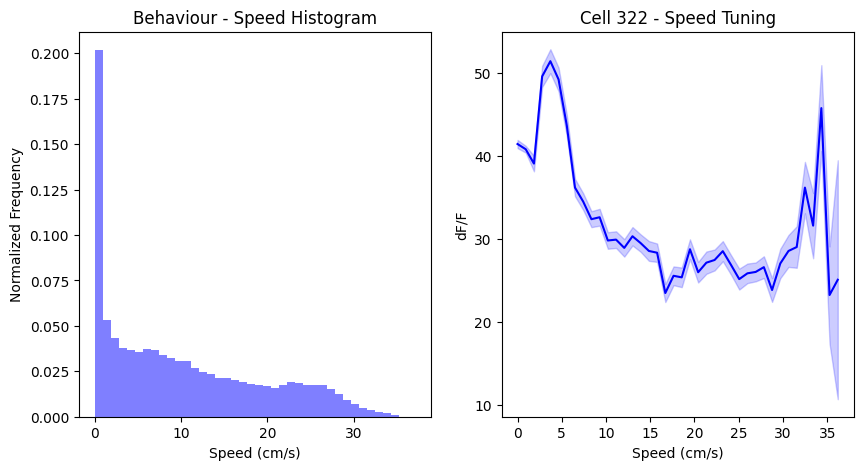

In [ ]:
fr_per_spbin, speed_hist,speed_edges = cellTV.extract_speed_tuning(dF, cell, session, bins=40, plot=True)

### Lick tuning (only taking first licks per LM to account for lick bouts and reward consumption)

In [ ]:
lick_frames, lin_first_licks = cellTV.extract_lick_tuning(dF, cell, session, frame_rate=45, window_size=[-1,5], plot=True)

AssertionError: This function has not been adapted to continuous corridors yet.

### Peri-event time histograms to any arbitrary events 
This function is identical to extracting reward or lick tuning if supplied with reward/lick indices, but can be used for subsampling or other arbitrary event analyses

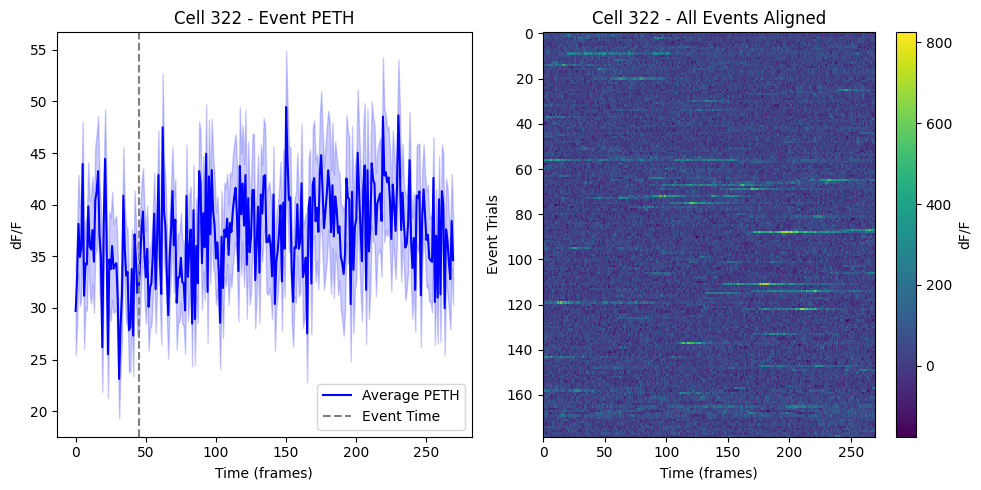

In [ ]:
peth_frames = cellTV.extract_arb_peth(dF,cell,lin_first_licks, frame_rate=45, window_size=[-1,5], plot=True)

### Cell's correlation with all other cells in that FOV

Top 5 correlated cells: [318 156  42 257 322], correlations: [0.08984503 0.09233981 0.10058968 0.10563562 1.        ]
Bottom 5 correlated cells: [438 224 255  62 390], correlations: [-0.1408729  -0.11438456 -0.11326945 -0.10930011 -0.09892071]


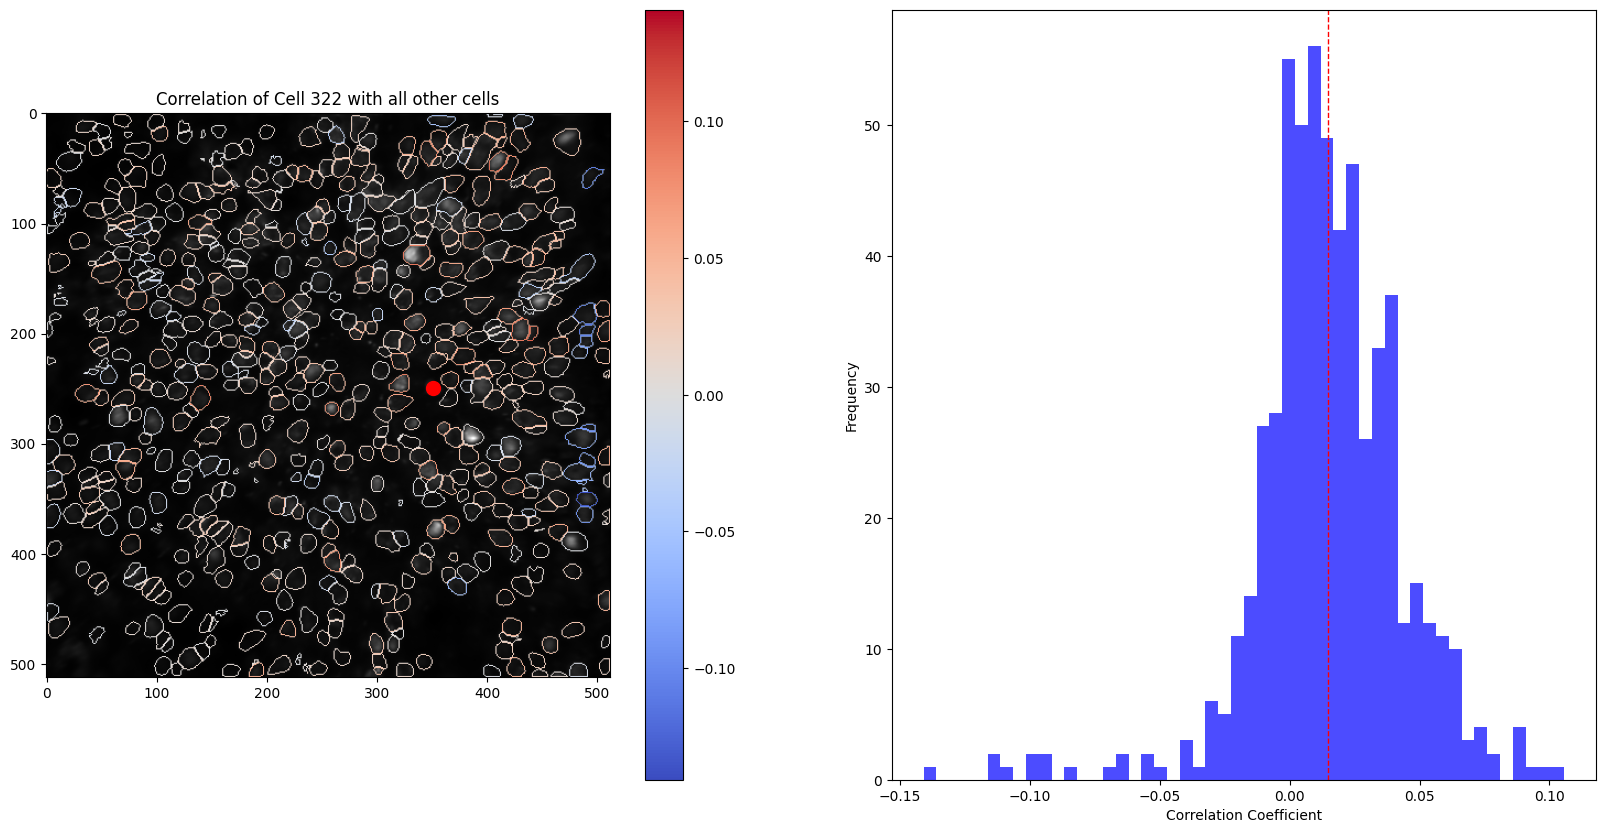

In [ ]:
cellTV.extract_cell_correlation(dF, cell, ops, seg, session=None, plot=True)